# Laboratorium 2 - Detekcja "twarzy" żółwi morskich 🐢

## Wstęp

YOLOX to kolejna odsłona architektury szyldowanej skrótem YOLO. Została zaproponowana w 2021 roku w artykule naukowym: https://arxiv.org/pdf/2107.08430v2.pdf.

Główna zmiana która nastepuje w porównaniu do poprzednich wersji to głowa tej sieci (a właściwie głów bo są ich aż 3). Z tego co można wyczytać w publikacji, szkielet sieci (z ang. `backbone`), pochodzi z YOLOv5, natomiast zaproponowana głowa wprowadza coś zupełnie nowego. Mianowicie chodzi o podejście `NMS-free` gdzie skrót `NMS` oznacza `Non-Maximum Suppression`. Poprzednie sieci, nawet te nowsze jak v4 czy v5 wciąż swoją detekcje opierały na tworzeniu siatki prostokątów na obrazie (z ang. `anchor boxes`) i sprawdzaniu każdego z nich czy zawiera on szukany obiekt.

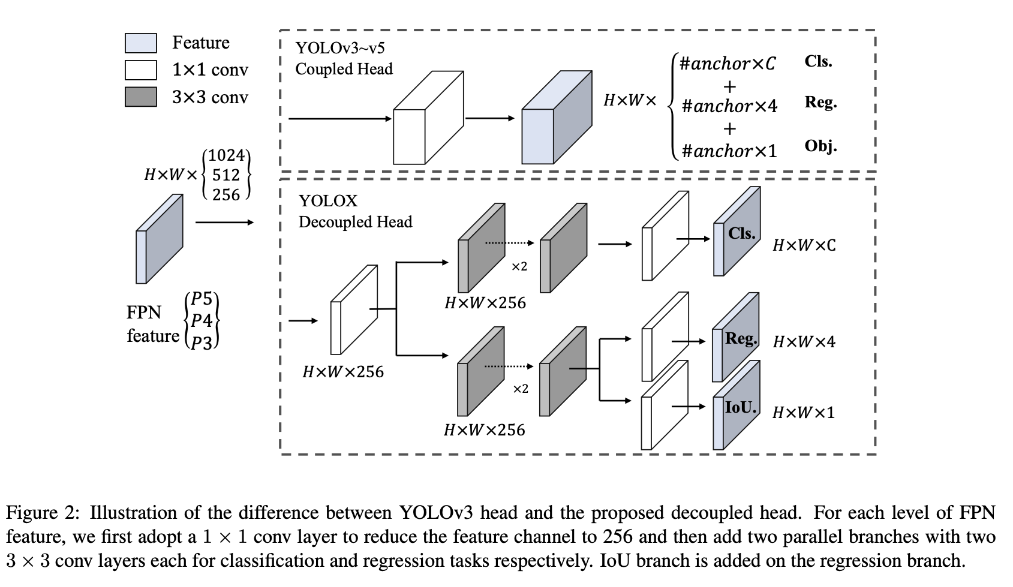

Dlaczego autorzy chcieli pozbyć się tego podejścia? - Wymaga ono dodatkowych obliczeń służących do przetworzenia wszystkich proponowanych prostokątów i wykonania dużej ilości predykcji na każdym z obrazków co wydłuża czas wnioskowania.



In [ ]:
import warnings
warnings.filterwarnings("ignore")

import ast
import os
import json
import pandas as pd
import torch
import importlib
import cv2
import shutil

from shutil import copyfile
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import GroupKFold
from PIL import Image
from string import Template
from IPython.display import display

In [ ]:
# check Torch and CUDA Version
print(f"Torch: {torch.__version__}")
!nvidia-smi

# 1. Instalacja YOLOX

Repozytorium YOLOX jest ogólnodostępne na licencji Apache 2.0 więc można stosować tę architekturę nawet w rozwiązaniach komercyjnych.

Link do repo: https://github.com/Megvii-BaseDetection/YOLOX

In [ ]:
!git clone https://github.com/Megvii-BaseDetection/YOLOX -q

%cd YOLOX
!pip install -U pip && pip install -r requirements.txt
!pip install -v -e .
%cd ..

Potrzebne będzie nam również Pythonowe API zbioru danych COCO.

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# 2. Przygotowanie zbioru danych - Format COCO

## 2.1 Przygotowanie zdjęć i oznaczeń

Dane pochodzą z platformy kaggle (https://www.kaggle.com/datasets/smaranjitghose/sea-turtle-face-detection?resource=download) i przedstawiają ok. 2000 zdjęć żółwi morskich, a oznaczenia zawarte w zbiorze wskazuja na ich głowy.

Instrukcja do pobrania danych z kaggle: https://www.kaggle.com/discussions/general/74235

Funkcje pomocnicze

In [ ]:
ANNOTATIONS_DIR = 'sea-turtle-face-detection/data/labels'
IMAGES_DIR = 'sea-turtle-face-detection/data/images'

def get_image_path(row):
    for filename in os.listdir(IMAGES_DIR):
        if filename.startswith(row.imagename):
            return os.path.join(IMAGES_DIR, filename)
    return None

def get_annot_path(row):
    return os.path.join(ANNOTATIONS_DIR, f"{row.imagename}.txt")

def get_bboxes(annot_path):
    if annot_path.endswith('.txt'):
        """
        Zaimplementuj który zwróci wszystkie oznaczenia z pliku annotacyjnego (bez klasy).
        annotation_list powinno być typu List[List[float]].
        Przykład zwracanej annotacji z dwoma oznaczeniami -> [[0.34, 0.72, 0.09, 0.123], [0.43, 0.87, 0.142, 0.89]]
        """
        return annoatations_list
    else:
        return None

def check_if_image_and_annot_exists(row):
    annot_path = get_annot_path(row)
    image_path = get_image_path(row)
    return os.path.isfile(image_path) and os.path.isfile(annot_path)

Wyekstrachowanie oznaczeń (`bounding boxes`) i preprocessing

In [ ]:
df = #TODO wczytaj plik csv
df = df[[5,6,7]]
df = df.rename(columns={
    5: "imagename",
    6: "image_width",
    7: "image_height"
})

#Kolumna z nazwami obrazów/ozbaczeń bez rozszerzenia
df['imagename'] = df['imagename'].apply(lambda x: x.split('.')[0])

#Pozostawiamy tylko wpisy które posiadają i annotacje i obraz
df = #TODO
df = df.reset_index(drop=True)

#Ekstrackcja oznaczeń w formacie typowym dla poprzednich wersji yolo
df['annot_path'] = df.apply(get_annot_path, axis=1)
df['image_path'] = df.apply(get_image_path, axis=1)
df['bboxes_yolo_format'] = df['annot_path'].apply(get_bboxes)
df['num_bbox'] = df['bboxes_yolo_format'].apply(len)
df

Podział na train, test

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = #TODO

Struktura zbioru danych w formacie COCO

In [ ]:
DATASET_DIR = 'dataset/images'
if os.path.exists(DATASET_DIR):
    shutil.rmtree(DATASET_DIR)
os.makedirs(DATASET_DIR)

os.makedirs(os.path.join(DATASET_DIR, 'train2017'))
os.makedirs(os.path.join(DATASET_DIR, 'val2017'))
os.makedirs(os.path.join(DATASET_DIR, 'annotations'))

Kopiowanie danych

In [ ]:
for idx, row in train_df.iterrows():
    """
    Wczytaj wszystkie zdjęcia po kolei, przekonwertuj obrazy do przestrzeni RGB i zapisz w odpowiednich folderach stworzonych komórkę wyżej.
    Zdjęcia powinny być zapisane w formacie .jpg
    """
for idx, row in val_df.iterrows():
    """
    To samo dla zbioru walidacyjnego
    """

In [ ]:
print(f'Number of training files: {len(os.listdir(f"{DATASET_DIR}/train2017/"))}')
print(f'Number of validation files: {len(os.listdir(f"{DATASET_DIR}/val2017/"))}')

## 2.2 Tworzenie oznaczeń w formacie COCO

Funkcja pomocnicza zapisująca pythonowy słownik jako oznaczenie z rozszerzeniem `.json`

In [ ]:
def save_annot_json(json_annotation, filename):
    with open(filename, 'w') as f:
        output_json = #TODO zapisz json_annotations jako plik json
        f.write(output_json)

Funkcja konwertująca podany pandasowy DataFrame do annotacji coco.

In [ ]:
def yolo2coco(df, images_dir):
    annotion_id = 0

    annotations_json = {
        "info": [],
        "licenses": [],
        "categories": [],
        "images": [],
        "annotations": []
    }

    info = {
        "year": "2022",
        "version": "1",
        "description": "Sea Trutle Dataset - COCO format",
        "contributor": "",
        "url": "https://kaggle.com",
        "date_created": "2022-10-09T15:01:26+00:00"
    }
    annotations_json["info"].append(info)

    lic = {"id": 1, "url": "", "name": "Unknown"}
    annotations_json["licenses"].append(lic)

    classes = {"id": 0, "name": "sea_turtle", "supercategory": "none"}
    annotations_json["categories"].append(classes)

    annots_num = 0
    for idx, row in df.iterrows():
        image_name = row.image_path.split('/')[-1]
        if os.path.isfile(os.path.join(images_dir, f"{row.imagename}.jpg")):
            annots_num += 1

            img_width = row.image_width
            img_height = row.image_height

            images = {
                "id": idx,
                "license": 1,
                "file_name": f"{row.imagename}.jpg",
                "height": img_height,
                "width": img_width,
                "date_captured": "2022-10-09T15:01:26+00:00"
            }
            annotations_json["images"].append(images)

            bbox_list = row.bboxes_yolo_format

            for bbox in bbox_list:
                bbox = [float(value) for value in bbox]
                center_x = bbox[0] * img_width
                center_y = bbox[1] * img_height
                b_width = bbox[2] * img_width
                b_height = bbox[3] * img_height

                image_annotations = {
                    "id": annotion_id,
                    "image_id": idx,
                    "category_id": 0,
                    "bbox": [
                        center_x - (b_width / 2),
                        center_y - (b_height / 2),
                        b_width,
                        b_height
                    ],
                    "area": b_width * b_height,
                    "segmentation": [],
                    "iscrowd": 0
                }
                annotion_id += 1
                annotations_json["annotations"].append(image_annotations)

    print(f"Dataset COTS annotation to COCO json format completed! Files: {annots_num}")
    return annotations_json

Konwersja i zapisanie oznaczeń

In [ ]:
train_images_dir = os.path.join(DATASET_DIR, "train2017")
val_images_dir = os.path.join(DATASET_DIR, "val2017")

#TODO przekonwertuj i zapisz anotacje do folderu annotations jako pliki json, użyj funkcji yolo2coco oraz save_annot_json dla danych treningowych i walidacyjnych
train_annot_json = #TODO
val_annot_json = #TODO


# 3. Przygotowanie pliku konfiguracyjnego do treningu

Przykładowe pliki konfiguracyjne YOLOX:
- [YOLOX-tiny](https://github.com/Megvii-BaseDetection/YOLOX/blob/main/exps/default/yolox_tiny.py)
- [YOLOX-s](https://github.com/Megvii-BaseDetection/YOLOX/blob/main/exps/default/yolox_s.py)
- [YOLOX-m](https://github.com/Megvii-BaseDetection/YOLOX/blob/main/exps/default/yolox_m.py)

Poniżej porównanie rozmiarów sieci

<div align="center"><img  width="800" src="https://github.com/Megvii-BaseDetection/YOLOX/raw/main/assets/git_fig.png"/></div>

## 3A. Przygotowanie pliku konfigurującego eksperyment

Powyzęj znajdziecie linki do przykładowych plików konfiguracyjnych, w poniższym należy tylko uzupełnić wyznaczone pola.

In [ ]:
config_file_template = '''

#!/usr/bin/env python3
# -*- coding:utf-8 -*-
# Copyright (c) Megvii, Inc. and its affiliates.

import os

from yolox.exp import Exp as MyExp

class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 0.33
        self.width = 0.50
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]


        self.data_dir = PODAJ ŚĆIEŻKĘ DO DO FOLDERU 'images' W STWORZONYM ZBIORZE DANYCH COCO
        self.train_ann = "train.json"
        self.val_ann = "valid.json"

        self.num_classes = 1
        self.max_epoch = #ILOŚĆ EPOK
        self.data_num_workers = 2
        self.eval_interval = 1

        #USTAWIENIA AUGMENTACJI
        self.mosaic_prob = 0.5
        self.mixup_prob = 0.0
        self.hsv_prob = 1.0
        self.flip_prob = 0.5
        self.no_aug_epochs = 2

        self.input_size = (640, 640)
        self.mosaic_scale = (0.5, 1.5)
        self.random_size = (10, 20)
        self.test_size = (640, 640)
        self.save_history_ckpt = False
'''

Stworzenie pliku konfiguracyjnego i zapis

In [ ]:
PIPELINE_CONFIG_PATH='turtle_config.py'
pipeline = Template(config_file_template).substitute(max_epoch = 20)
with open(PIPELINE_CONFIG_PATH, 'w') as f:
    #TODO zapisz pipeline do pliku PIPELINE_CONFIG_PATH

Dodatkowe zmienne potrzebne do mapowania klas

In [ ]:
# ./yolox/data/datasets/voc_classes.py

voc_cls = '''
VOC_CLASSES = (
  "sea_turtle",
)
'''
with open('YOLOX/yolox/data/datasets/voc_classes.py', 'w') as f:
    f.write(voc_cls)

# ./yolox/data/datasets/coco_classes.py

coco_cls = '''
COCO_CLASSES = (
  "sea_turtle",
)
'''
with open('YOLOX/yolox/data/datasets/coco_classes.py', 'w') as f:
    f.write(coco_cls)

# check if everything is ok
!more YOLOX/yolox/data/datasets/coco_classes.py

# 4. Pobranie pretrenowanych wag

In [ ]:
sh = 'wget https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_s.pth'

with open('script.sh', 'w') as file:
    file.write(sh)

!bash script.sh

In [ ]:
MODEL_FILE = 'yolox_s.pth'

# 5. Trening modelu

In [ ]:
!cp YOLOX/tools/train.py ./

In [ ]:
torch.cuda.empty_cache()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!rm -rf YOLOX_outputs

In [ ]:
!python YOLOX/tools/train.py -f turtle_config.py  -b 16  -d 1 --fp16 -c {MODEL_FILE}

In [ ]:
# !python YOLOX/tools/train.py \
#     -f turtle_config.py \          # Ścieżka do configu
#     -b 16 \                        # Batch size
#     -d 1 \                         # Liczba GPU na ilu chcemy trenować
#     --fp16 \                       # Half precision - wagi zapisywane są z precyzją 16 bitów zamiast 32 aby model był "lżejszy"
#     -c {MODEL_FILE}                # Path to the model file

# 6. Wnioskowanie modelu

In [ ]:
import sys
sys.path.insert(0,'/home/ai/student1/lab/lab2turtle/YOLOX')

from yolox.utils import postprocess
from yolox.data.data_augment import ValTransform

COCO_CLASSES = (
  "sea_turtle",
)

# get YOLOX experiment
current_exp = importlib.import_module('turtle_config')
exp = current_exp.Exp()
exp.depth = 0.33
exp.width = 0.5


# set inference parameters
test_size = (640, 640)
num_classes = 1
confthre = 0.5  # Threshold pewności modelu - poniżej tej pewności nie detekcje będą odrzucane
nmsthre = 0.45


# get YOLOX model
model = exp.get_model()
model.cuda()
model.eval()

# get custom trained checkpoint
ckpt_file = "./YOLOX_outputs/cots_config/best_ckpt.pth"
ckpt = torch.load(ckpt_file, map_location="cuda:0")
model.load_state_dict(ckpt["model"])

### 6.2 Zwracanie interpretowalnych oznaczeń

In [ ]:
def yolox_inference(img, model, test_size):
    bboxes = []
    bbclasses = []
    scores = []

    preproc = ValTransform(legacy = False)

    tensor_img, _ = preproc(img, None, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    tensor_img = tensor_img.cuda()

    with torch.no_grad():
        outputs = model(tensor_img)
        outputs = postprocess(
                    outputs, num_classes, confthre,
                    nmsthre, class_agnostic=True
                )

    if outputs[0] is None:
        return [], [], []

    outputs = outputs[0].cpu()
    bboxes = outputs[:, 0:4]

    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]

    return bboxes, bbclasses, scores

### 6.3 Rysowanie oznaczeń

In [ ]:
def draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, classes_dict):
    for i in range(len(bboxes)):
            """
            Napisz funkcję któna rysuje każde zwrócone oznaczenie przez model.
            Dodatkowo napisz do jakiej klasy należy oznaczenie i % pewności modelu.
            Podpowiedź: bbox jest zwracany w taki sposób - [x_left_upper_corner, y_left_upper_corner, x_right_down_corner, y_right_down_corner]
            """
    return img

### 6.4 Wszystko razem!

In [ ]:
img = cv2.imread(val_df.image_path.iloc[10])

bboxes, bbclasses, scores = yolox_inference(img, model, test_size)

# Narysuj predykcje używając draw_yolox_predictions
out_image = #TODO

# Ponieważ ładujemy obraz za pomocą OpenCV, musimy go przekonwertować
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))

## 6.5 Użycie sieci na video

In [ ]:
# TODO: pobierz filmik z youtube przy pomocy biblioteki pytube


# TODO: wytnij interesujący fragment zawierający żółwie przy pomocy moviepy

In [ ]:
# wczytaj przygotowane video
videofile = 'test_video.mp4'
frames = []

In [ ]:
video = cv2.VideoCapture(videofile)

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
w = video.get(cv2.CAP_PROP_FRAME_WIDTH);
h = video.get(cv2.CAP_PROP_FRAME_HEIGHT);
fps = video.get(cv2.CAP_PROP_FPS)
total_frames = int(video.get(cv2. CAP_PROP_FRAME_COUNT))

success, image = video.read()
result_video=cv2.VideoWriter('./test_result.mp4',fourcc,fps,(int(w),int(h)))
count = 0
while success:
        """TODO: Użyj sieci na video analogicznie jak w przypadku rysowania predykcji na obrazku"""
        result_video.write(out_image)
        success,image = video.read()
        count += 1
        if count % 100 == 0:
            print(f"Processed {count}/{total_frames} frames.")
video.release()
result_video.release()